In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL.Image import open
from sklearn.preprocessing import MinMaxScaler
from random import shuffle
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout
%matplotlib inline
print(os.getcwd())

c:\Python\Kontur


# Введение

В настоящей работе необходимо предсказать, сгенерировано ли изображение при помощи ИИ или нет. <br/>
Данными являются изображения, которые нужно проанализировать. <br/>
Тренировочная выборка имеет поля: названия файла с изображением, таргет (вероятность того, что изображение сгенерировано) <br/>
Тестовая выборка имеет только поле id

## Визуальный осмотр


Первое, что можно сделать, это визуально оценить изображения.
В ходе просмотра былы выделены следующие особенности сгенерированных изображений.
1. Изображения имеют квадратное соотношение сторон
2. Изображения имеют артефакты, такие как: лишние конечности, зубы, неправильное отображение глаз
3. Изображения имеют приглушенные/теплые тона
4. Текстура изображения достаточно плавная (т.е. нет шума цифровой камеры) <br/>
Пример такого изображения<br/>
![title](images/0bAvf1FcUP.jpeg)

Стоит отметить, что указанные выше особенности, применимы не ко всем изображениям.<br/>
Например его могут отличать только артефакты на изображении.<br/>
![title](images/1EkEeqlGtK.png)

# Анализ данных

Для анализа соединим тренировочный и тестовый датасет. Для тестового датасета таргет заполним 0.5 (это необходимо для дальнейшей нормализации данных)

In [2]:
training_df = pd.read_csv('train.csv')
testdf = pd.read_csv('test.csv')
train_df = pd.concat([training_df, testdf], ignore_index=True)
train_df.fillna(value={'target':0.5}, inplace=True)
train_df

,id,target
0,gL5fWrgNPU.jpg,0.0
1,KKWXJDN8uM.png,1.0
2,Wb2I0CXlAY.jpg,0.0
3,G7PLhKpaf7.jpeg,1.0
4,DEUkeefz6Z.jpg,0.0
...,...,...
1513,Qrme6EUmL1,0.5
1514,4369Dl8wfs.jpeg,0.5
1515,BrNEvRNpPu.jpeg,0.5
1516,DuwXCNmeMx.webp,0.5


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1518 entries, 0 to 1517
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1518 non-null   object 
 1   target  1518 non-null   float64
dtypes: float64(1), object(1)
memory usage: 23.8+ KB


Группирование данных по таргету показывает, что данные несбалансированны. Это может повлиять на предвзятость модели при классификации. В дальнейшем может понадобиться балансировка классов. 

In [4]:
train_df.groupby('target').count()

,id
target,
0.0,667
0.5,506
1.0,345


## Анализ изображений по имени

В этом разделе проведен анализ по имени. Поиск закономерности в имени файла и в формате.

In [5]:
list(set([i.split('.')[1] for i in os.listdir('images')]))

['jpg', 'png', 'jpeg', 'webp']

Получение полных названий изображений

In [6]:
train_df[['name','format']] = train_df['id'].str.split('.', expand=True)
train_df

,id,target,name,format
0,gL5fWrgNPU.jpg,0.0,gL5fWrgNPU,jpg
1,KKWXJDN8uM.png,1.0,KKWXJDN8uM,png
2,Wb2I0CXlAY.jpg,0.0,Wb2I0CXlAY,jpg
3,G7PLhKpaf7.jpeg,1.0,G7PLhKpaf7,jpeg
4,DEUkeefz6Z.jpg,0.0,DEUkeefz6Z,jpg
...,...,...,...,...
1513,Qrme6EUmL1,0.5,Qrme6EUmL1,None
1514,4369Dl8wfs.jpeg,0.5,4369Dl8wfs,jpeg
1515,BrNEvRNpPu.jpeg,0.5,BrNEvRNpPu,jpeg
1516,DuwXCNmeMx.webp,0.5,DuwXCNmeMx,webp


Обнаружено, что в поле id имя файла может быть без его формата. Необходимо восставить полностью имя файлов для дальнейшего анализа.

In [7]:
train_df[train_df['format'].isna()]

,id,target,name,format
6,hG9nlBfDeh,1.0,hG9nlBfDeh,None
22,Evdusx0Cel,1.0,Evdusx0Cel,None
23,jsCvbsKj7U,1.0,jsCvbsKj7U,None
27,up31h8HYKk,1.0,up31h8HYKk,None
28,8mtNcVjofj,1.0,8mtNcVjofj,None
...,...,...,...,...
1493,ufRMShYCAN,0.5,ufRMShYCAN,None
1496,eYjjwfVtVX,0.5,eYjjwfVtVX,None
1500,C7rJv18MLh,0.5,C7rJv18MLh,None
1508,YL2iLPQAgZ,0.5,YL2iLPQAgZ,None


In [8]:
img_format = {i.split('.')[0]:i.split('.')[1] for i in os.listdir('images')}
for name in train_df[train_df['format'].isna()]['name']:
    train_df.loc[train_df['name'] == name, 'format'] = img_format[name]
train_df['image name'] = train_df['name'] + '.' + train_df['format']
train_df

,id,target,name,format,image name
0,gL5fWrgNPU.jpg,0.0,gL5fWrgNPU,jpg,gL5fWrgNPU.jpg
1,KKWXJDN8uM.png,1.0,KKWXJDN8uM,png,KKWXJDN8uM.png
2,Wb2I0CXlAY.jpg,0.0,Wb2I0CXlAY,jpg,Wb2I0CXlAY.jpg
3,G7PLhKpaf7.jpeg,1.0,G7PLhKpaf7,jpeg,G7PLhKpaf7.jpeg
4,DEUkeefz6Z.jpg,0.0,DEUkeefz6Z,jpg,DEUkeefz6Z.jpg
...,...,...,...,...,...
1513,Qrme6EUmL1,0.5,Qrme6EUmL1,png,Qrme6EUmL1.png
1514,4369Dl8wfs.jpeg,0.5,4369Dl8wfs,jpeg,4369Dl8wfs.jpeg
1515,BrNEvRNpPu.jpeg,0.5,BrNEvRNpPu,jpeg,BrNEvRNpPu.jpeg
1516,DuwXCNmeMx.webp,0.5,DuwXCNmeMx,webp,DuwXCNmeMx.webp


In [9]:
train_df.groupby(['format', 'target'])['target'].count()

format  target
jpeg    0.5       420
        1.0       171
jpg     0.0       667
png     0.5        84
        1.0       174
webp    0.5         2
Name: target, dtype: int64

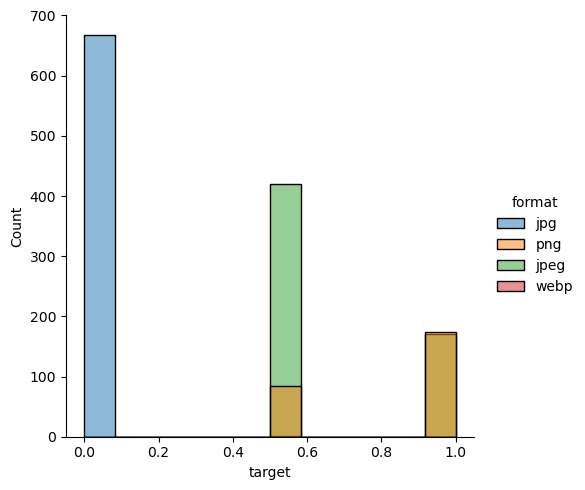

In [10]:
sns.displot(data = train_df, x="target", hue="format")

График распределения показывает, что формат изображения не несет в себе полезной информациии.

Создадим следующие категории и проверим.<br/><br/>
nlen - количество гласных символов в имени.<br/>
nlet - количество уникальных символов в имени.<br/>
fletter - с какого символа начинается имя. (Переведено в категориальный признак от 0 до n. Необходимо, если признак будет включен в обучение модели)

In [11]:
train_df['nlen'] = train_df['name'].apply(lambda x: len(list(filter(lambda y: y in 'eyuioaEYUIOA', x))))
train_df['nlet'] = train_df['name'].apply(lambda x: len(set(x.lower())))
train_df['fletter'] = train_df['name'].str[0].apply(lambda x: x.lower()).astype('category').cat.codes
train_df

,id,target,name,format,image name,nlen,nlet,fletter
0,gL5fWrgNPU.jpg,0.0,gL5fWrgNPU,jpg,gL5fWrgNPU.jpg,1,9,16
1,KKWXJDN8uM.png,1.0,KKWXJDN8uM,png,KKWXJDN8uM.png,1,9,20
2,Wb2I0CXlAY.jpg,0.0,Wb2I0CXlAY,jpg,Wb2I0CXlAY.jpg,3,10,32
3,G7PLhKpaf7.jpeg,1.0,G7PLhKpaf7,jpeg,G7PLhKpaf7.jpeg,1,8,16
4,DEUkeefz6Z.jpg,0.0,DEUkeefz6Z,jpg,DEUkeefz6Z.jpg,4,7,13
...,...,...,...,...,...,...,...,...
1513,Qrme6EUmL1,0.5,Qrme6EUmL1,png,Qrme6EUmL1.png,3,8,26
1514,4369Dl8wfs.jpeg,0.5,4369Dl8wfs,jpeg,4369Dl8wfs.jpeg,0,10,4
1515,BrNEvRNpPu.jpeg,0.5,BrNEvRNpPu,jpeg,BrNEvRNpPu.jpeg,2,7,11
1516,DuwXCNmeMx.webp,0.5,DuwXCNmeMx,webp,DuwXCNmeMx.webp,2,8,13


In [12]:
pd.set_option('display.max_rows', None)
display(train_df.groupby(['fletter', 'target'])['target'].count())
pd.set_option('display.max_rows', 10)

fletter  target
0        0.0       17
         0.5        8
         1.0        2
1        0.0       11
         0.5        9
         1.0        3
2        0.0       17
         0.5        6
         1.0        2
3        0.0       13
         0.5        8
         1.0        3
4        0.0       15
         0.5        3
         1.0        8
5        0.0       12
         0.5        6
         1.0        5
6        0.0       13
         0.5        9
         1.0        5
7        0.0        9
         0.5        9
         1.0        5
8        0.5       16
         1.0        5
9        0.5       24
         1.0        2
10       0.0        2
         0.5       41
         1.0        3
11       0.5       36
         1.0       13
12       0.0       20
         0.5       17
         1.0       15
13       0.0       33
         0.5        7
         1.0       13
14       0.0       31
         0.5        4
         1.0       15
15       0.0       28
         0.5        8
         1.0    

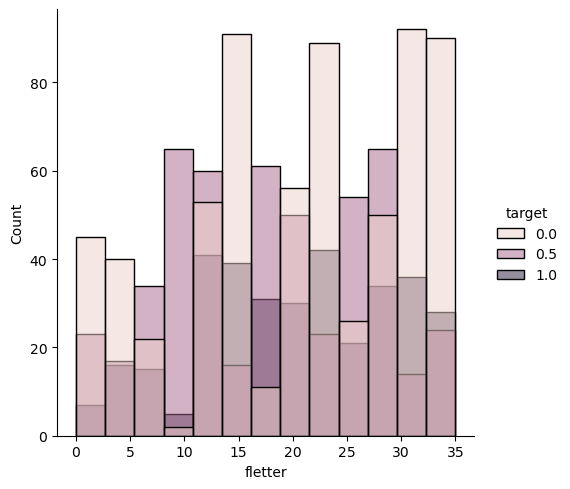

In [13]:
sns.displot(data = train_df, x="fletter", hue="target")

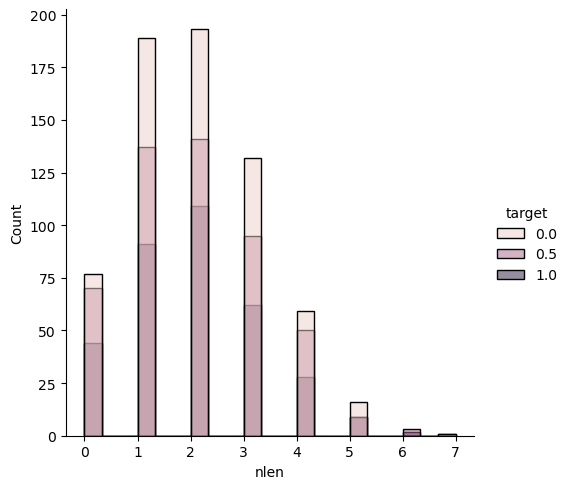

In [14]:
sns.displot(data = train_df, x="nlen", hue="target")
# plt.ylim(0,10)

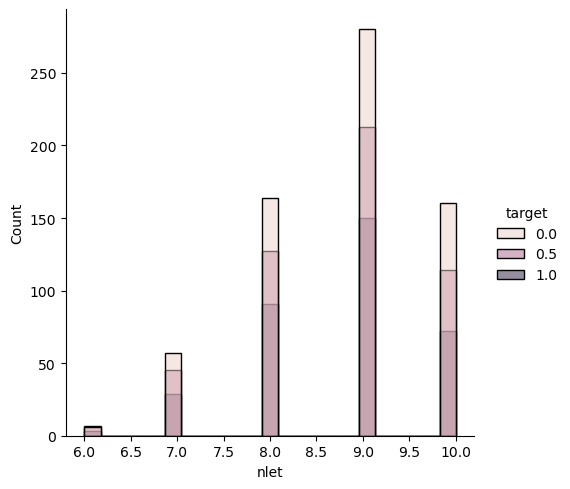

In [15]:
sns.displot(data = train_df, x="nlet", hue="target")
# plt.ylim(0,10)

Вывод: Анализ по имени не дал полезной информации. Зависимости не были найдены.

## Анализ конфигураций изображений

In [16]:
# Получаем размер файла
train_df['nsize'] = train_df['image name'].apply(lambda x: os.path.getsize(f'images/{x}'))

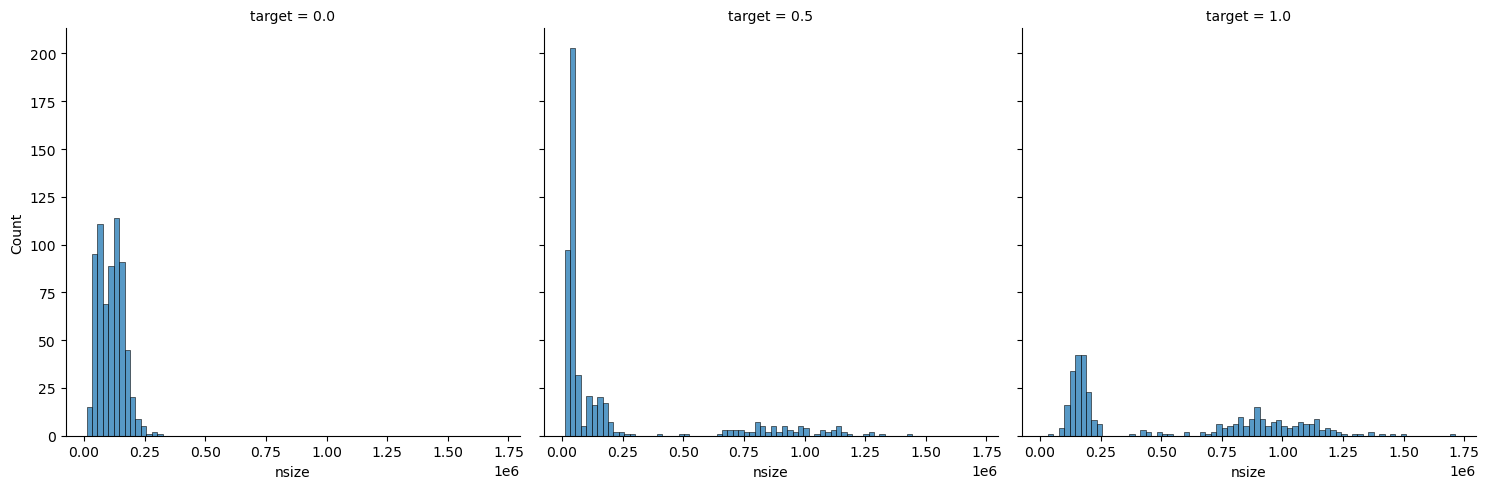

In [17]:
sns.displot(data = train_df, x="nsize", col="target")

Найдена первая зависимость. Сгенерированные изображения имеют больший размер файла.

Получим конфигурацию изображений, а менно:<br/>
1. Ширина
2. Высота
3. Площадь
4. Количество уникальных цветов. Было замечено ранее, что сгнерированные изображения имеют более плавную текстуру. Имеется ввиду, что одинаковых RGB пикселей должно быть больше.
5. Средняя яркость изображения. Было замечено ранее, что сгенерированные изображения имеют приглушенные тона.
6. Соотношение сторон. Рассчитывается соотношение от 0 до 1, где 1 означает, что изображение квадратное. Ранее ставилась пометка "Квадратное изображение", но при дальнейшем рассмотрении оказалось, что есть "хитрые" изображения с размером 600х599.

In [18]:
for indi, name in enumerate(train_df['image name'].values):
    im = cv2.imread(f'images/{name}')
    h, w, c = im.shape
    train_df.loc[indi, 'width'] = w
    train_df.loc[indi, 'height'] = h
    train_df.loc[indi, 'square'] = h*w
    train_df.loc[indi, 'colors'] = sum(np.unique(im.reshape(-1,3)))
    train_df.loc[indi, 'brightness'] = np.mean(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY))
train_df['ratio'] = np.where(train_df['width'] > train_df['height'], train_df['height'] / train_df['width'], train_df['width'] / train_df['height'])
train_df

,id,target,name,format,image name,nlen,nlet,fletter,nsize,width,height,square,colors,brightness,ratio
0,gL5fWrgNPU.jpg,0.0,gL5fWrgNPU,jpg,gL5fWrgNPU.jpg,1,9,16,93983,500.0,375.0,187500.0,32640.0,104.846512,0.750000
1,KKWXJDN8uM.png,1.0,KKWXJDN8uM,png,KKWXJDN8uM.png,1,9,20,414195,512.0,512.0,262144.0,31706.0,123.269505,1.000000
2,Wb2I0CXlAY.jpg,0.0,Wb2I0CXlAY,jpg,Wb2I0CXlAY.jpg,3,10,32,132514,375.0,500.0,187500.0,32640.0,101.080347,0.750000
3,G7PLhKpaf7.jpeg,1.0,G7PLhKpaf7,jpeg,G7PLhKpaf7.jpeg,1,8,16,199146,1024.0,1024.0,1048576.0,32640.0,78.122895,1.000000
4,DEUkeefz6Z.jpg,0.0,DEUkeefz6Z,jpg,DEUkeefz6Z.jpg,4,7,13,165773,500.0,375.0,187500.0,32640.0,127.571989,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513,Qrme6EUmL1,0.5,Qrme6EUmL1,png,Qrme6EUmL1.png,3,8,26,1067954,722.0,730.0,527060.0,31375.0,110.184188,0.989041
1514,4369Dl8wfs.jpeg,0.5,4369Dl8wfs,jpeg,4369Dl8wfs.jpeg,0,10,4,30823,500.0,333.0,166500.0,32640.0,125.261916,0.666000
1515,BrNEvRNpPu.jpeg,0.5,BrNEvRNpPu,jpeg,BrNEvRNpPu.jpeg,2,7,11,44490,500.0,375.0,187500.0,32640.0,141.307136,0.750000
1516,DuwXCNmeMx.webp,0.5,DuwXCNmeMx,webp,DuwXCNmeMx.webp,2,8,13,29998,668.0,669.0,446892.0,32640.0,186.034275,0.998505


In [19]:
# train_df['ratio'] = train_df['width'] / train_df['height']

In [20]:
# train_df['ratio'] = train_df['height'] / train_df['width']

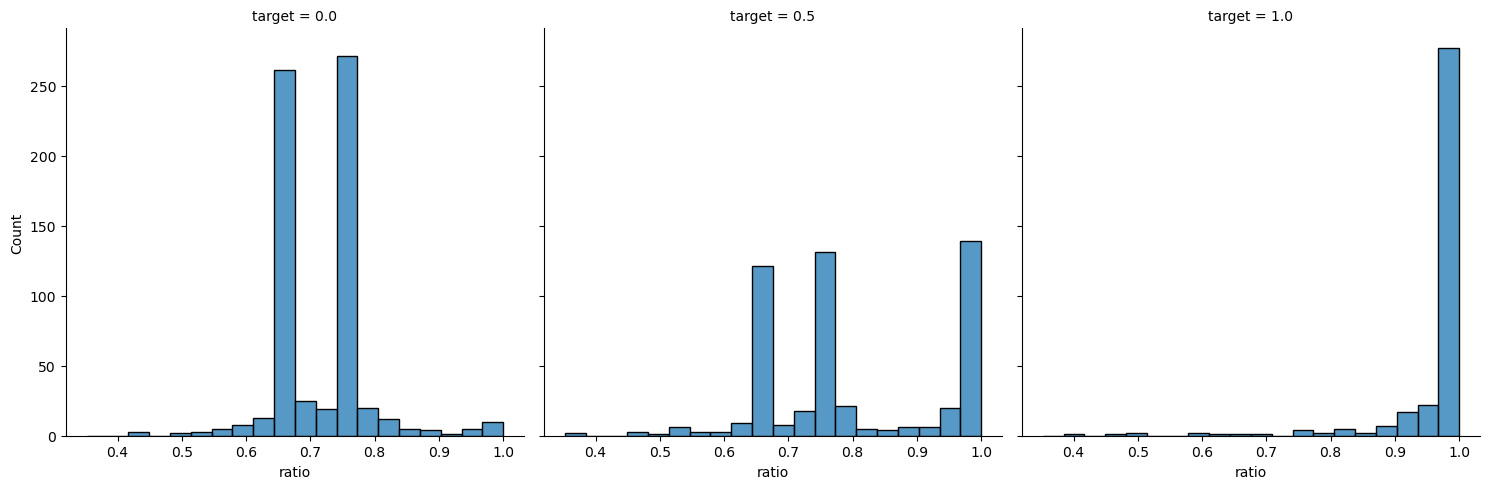

In [21]:
sns.displot(data = train_df, x="ratio", col="target", bins=20)

Соотношение сторон показывает явную закономерность

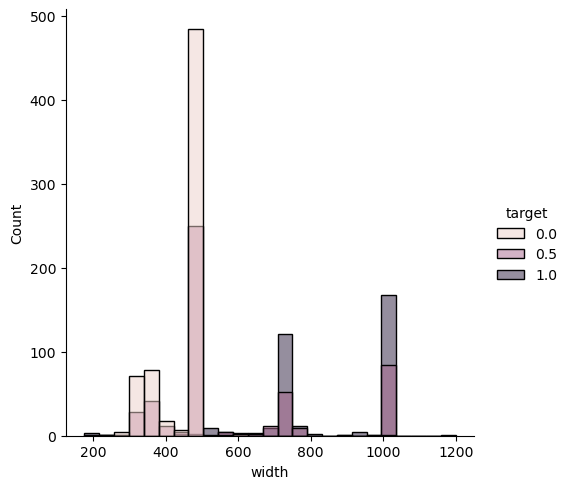

In [22]:
sns.displot(data = train_df, x="width", hue="target")

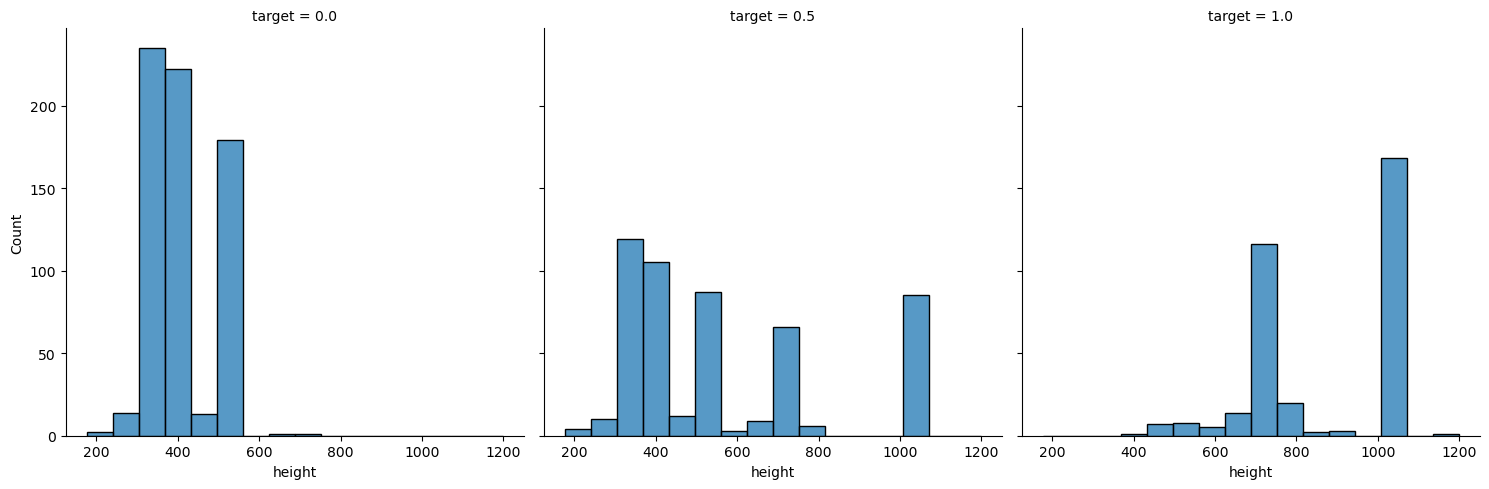

In [23]:
sns.displot(data = train_df, x="height", col="target")

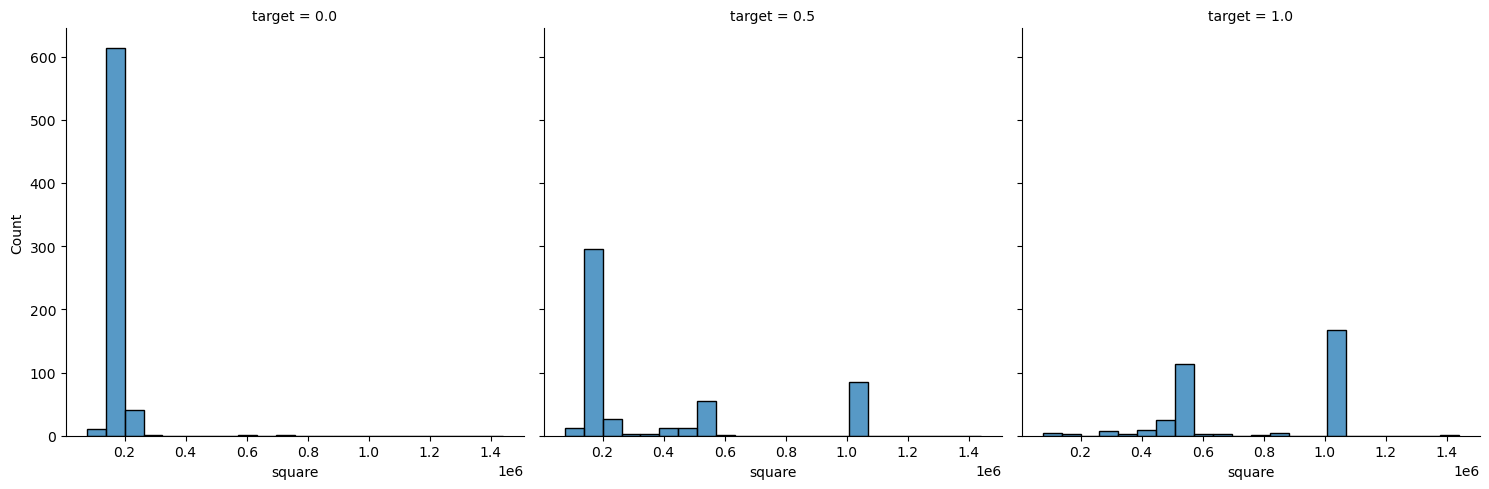

In [24]:
sns.displot(data = train_df, x="square", col="target")

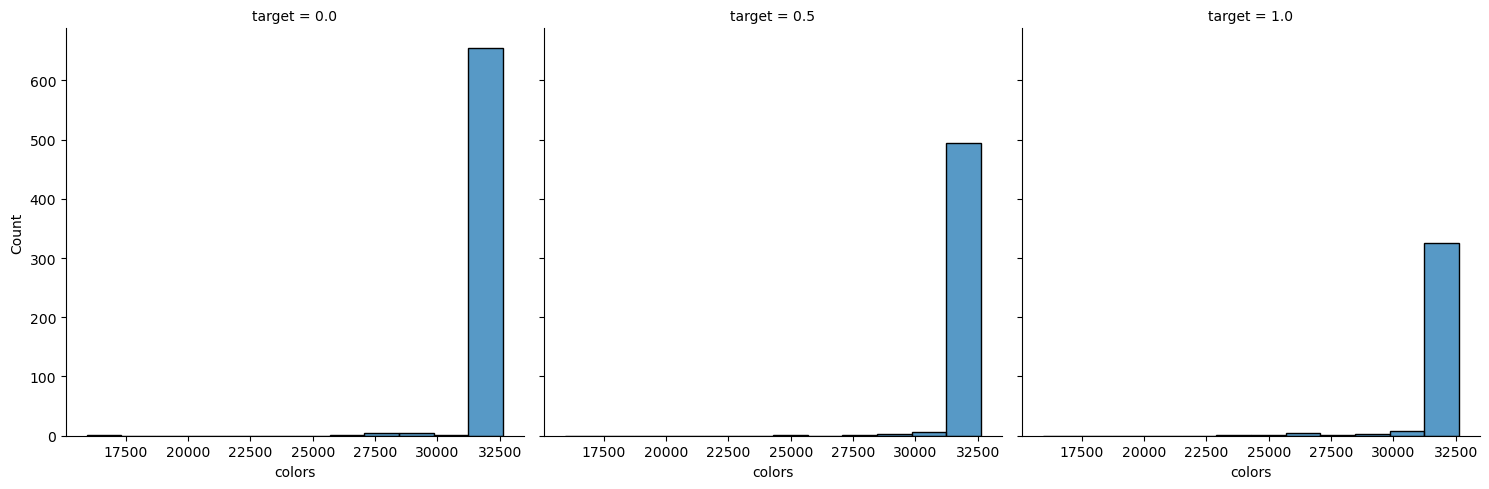

In [25]:
sns.displot(data = train_df, x="colors", col="target")

(0.0, 10.0)

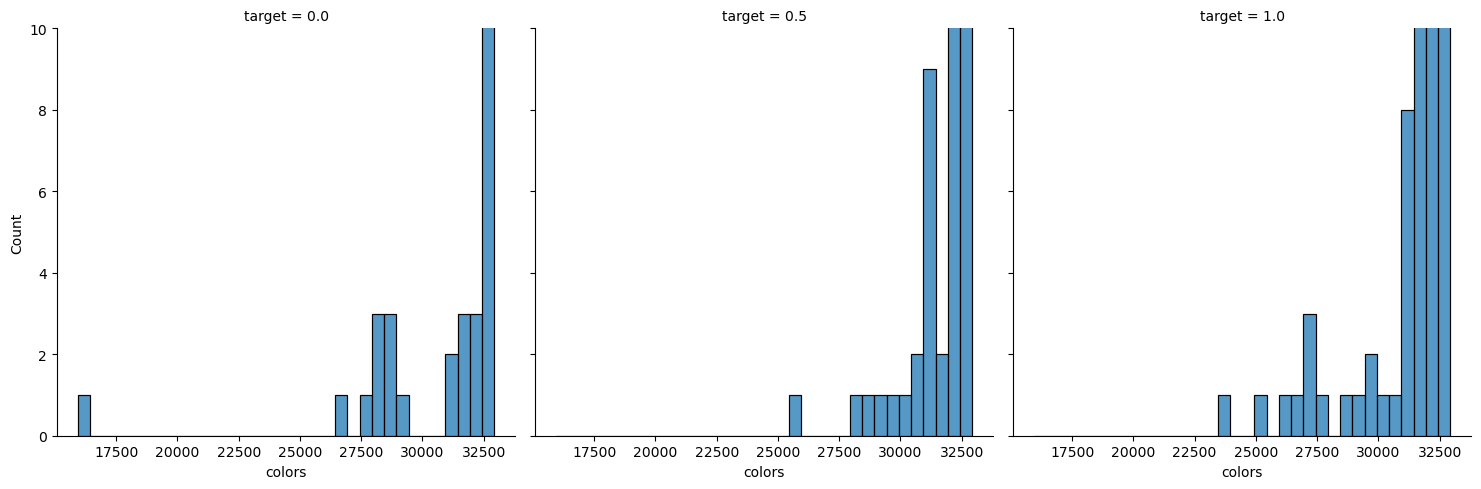

In [26]:
sns.displot(data = train_df, x="colors", col="target", binwidth = 500)
plt.ylim(0,10)

(29000.0, 33000.0)

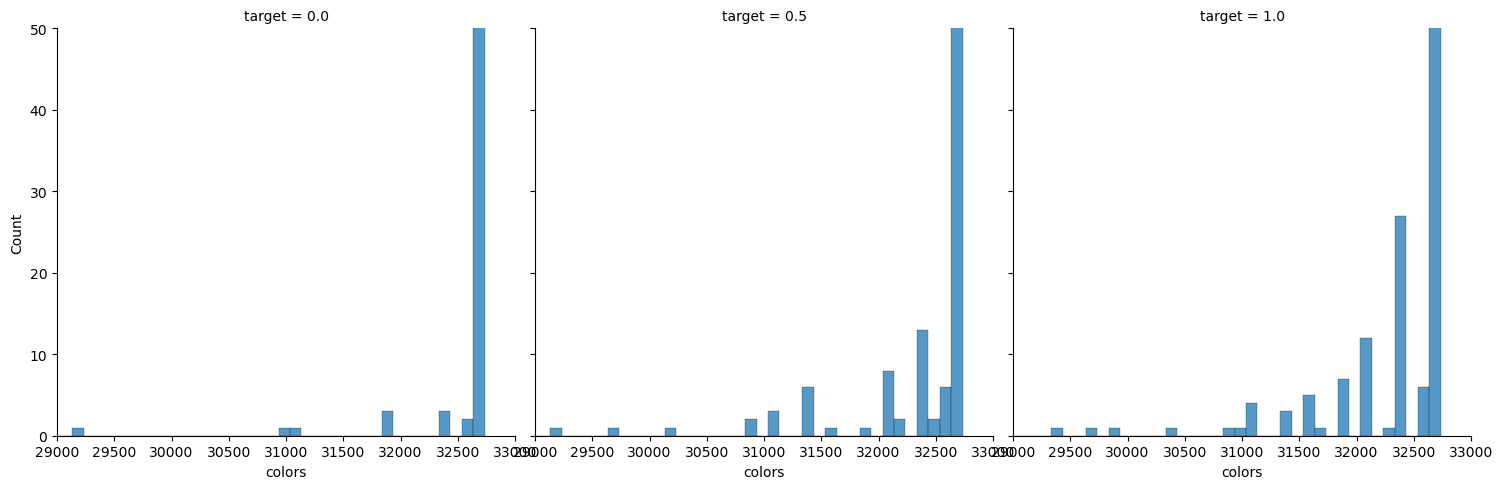

In [27]:
sns.displot(data = train_df, x="colors", col="target", binwidth = 100)
plt.ylim(0,50)
plt.xlim(29000, 33000)

(25000.0, 29000.0)

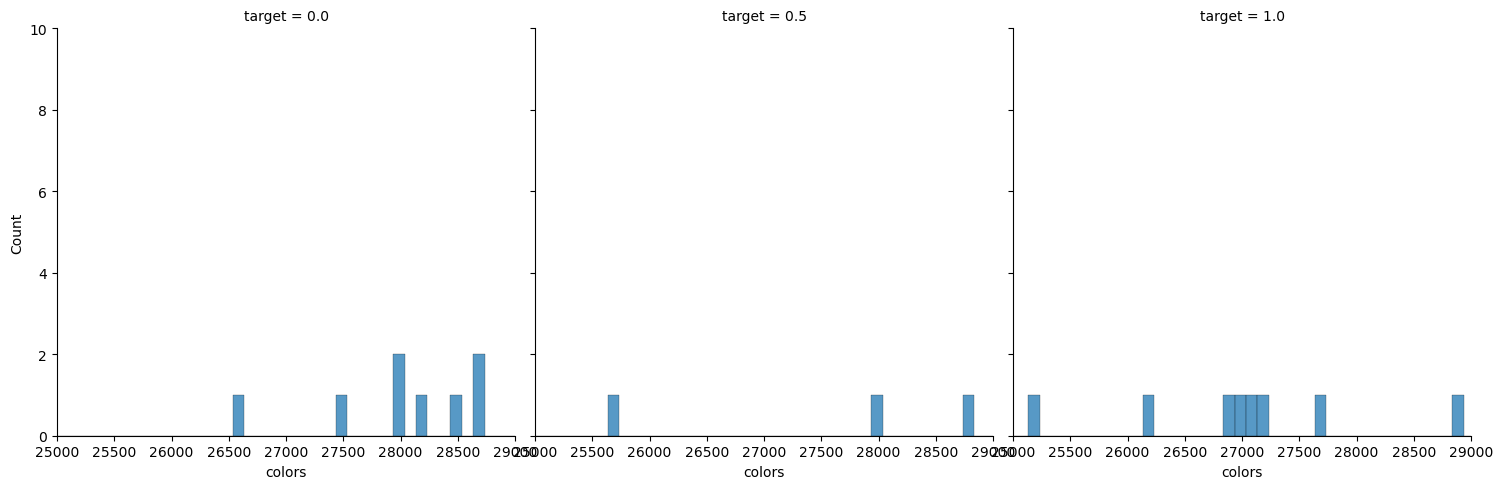

In [28]:
sns.displot(data = train_df, x="colors", col="target", binwidth = 100)
plt.ylim(0,10)
plt.xlim(25000, 29000)

UPD. При написании отчета, я понял, что поле colors не совсем корректно отражает зависимость. Хоть там и есть "какая-то" зависимость, лучше сделать отношение уникальных цветов ко всем.<br/>
Ниже приведен код.

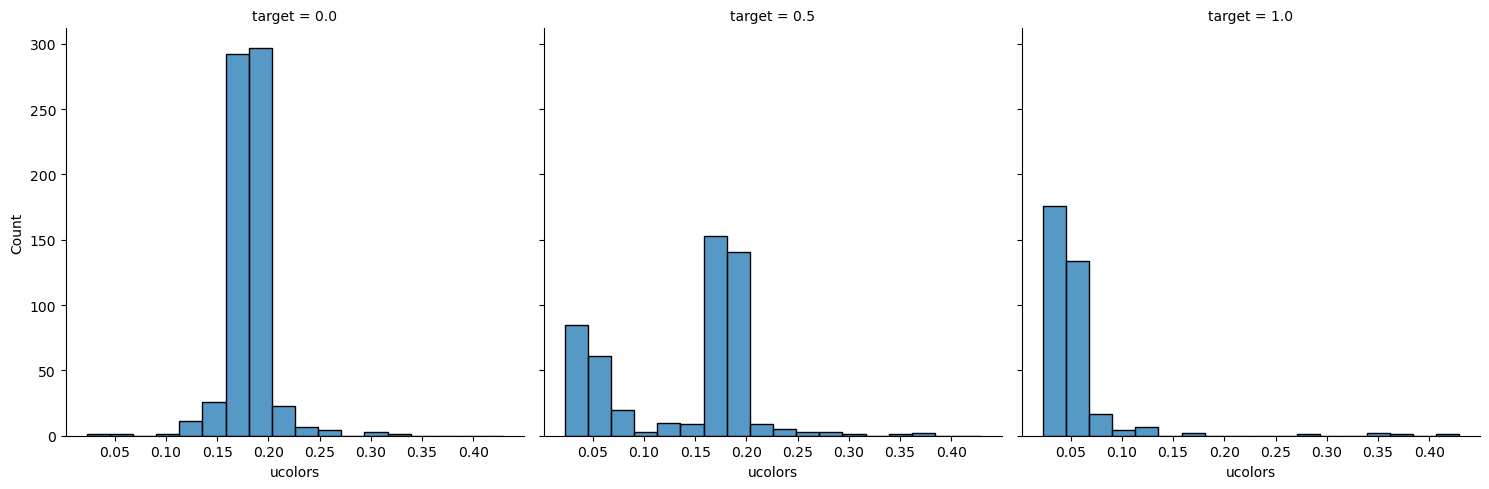

In [29]:
train_df['ucolors']= train_df['colors'] / train_df['square']
sns.displot(data = train_df, x="ucolors", col="target")

Теперь видна четкая зависимость. (Если при обучении заменить признак colors на ucolors, то результат становится лучше. см. главу "Обучение".)

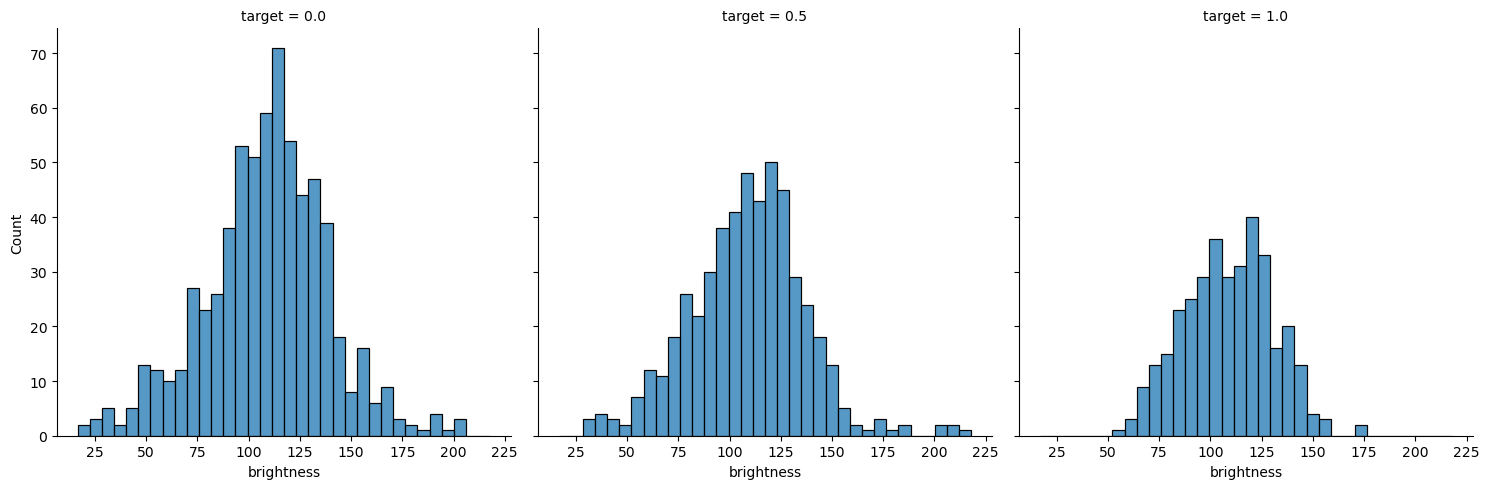

In [30]:
sns.displot(data = train_df, x="brightness", col="target")

Вывод: Все рассмотренные признаки, кроме яркости, имеют зависимость. 

## Анализ метаданных

Проведем проверку метаданных. Некоторые изображения имеют dpi.

In [31]:
for indi, i in enumerate(train_df.values):
    img = open(f'images/{i[4]}')
    if 'dpi' in img.info:
        if type(img.info['dpi'][0]) != int and type(img.info['dpi'][0]) != float: print(train_df.iloc[indi,[0,1,2,3]].values, img.info['dpi'][0])
        train_df.loc[indi, 'dpi'] = float(img.info['dpi'][0])
    else: train_df.loc[indi, 'dpi'] = 0
train_df

['QMXcln144D.jpg' 0.0 'QMXcln144D' 'jpg'] 300.0
['dhD3s1acTB.jpg' 0.0 'dhD3s1acTB' 'jpg'] 240.0
['UMOi3lMlXH.jpeg' 1.0 'UMOi3lMlXH' 'jpeg'] 96.0
['7mbuYSlfnk.jpg' 0.0 '7mbuYSlfnk' 'jpg'] 72.0
['wDQeBKRNHS.jpg' 0.0 'wDQeBKRNHS' 'jpg'] 72.0
['EcZf31BpeO.jpg' 0.0 'EcZf31BpeO' 'jpg'] 72.0
['Bz9RPbGAPC.jpeg' 1.0 'Bz9RPbGAPC' 'jpeg'] 96.0
['ErrxZIPAF4.jpg' 0.0 'ErrxZIPAF4' 'jpg'] 72.0
['O8CO8x6gFr.jpeg' 1.0 'O8CO8x6gFr' 'jpeg'] 96.0
['veiMOrSUGs.jpeg' 0.5 'veiMOrSUGs' 'jpeg'] 96.0
['XLEN3yCk0m.jpeg' 0.5 'XLEN3yCk0m' 'jpeg'] 96.0
['j3ujTADBT9.jpeg' 0.5 'j3ujTADBT9' 'jpeg'] 96.0


,id,target,name,format,image name,nlen,nlet,fletter,nsize,width,height,square,colors,brightness,ratio,ucolors,dpi
0,gL5fWrgNPU.jpg,0.0,gL5fWrgNPU,jpg,gL5fWrgNPU.jpg,1,9,16,93983,500.0,375.0,187500.0,32640.0,104.846512,0.750000,0.174080,2.0000
1,KKWXJDN8uM.png,1.0,KKWXJDN8uM,png,KKWXJDN8uM.png,1,9,20,414195,512.0,512.0,262144.0,31706.0,123.269505,1.000000,0.120949,0.0000
2,Wb2I0CXlAY.jpg,0.0,Wb2I0CXlAY,jpg,Wb2I0CXlAY.jpg,3,10,32,132514,375.0,500.0,187500.0,32640.0,101.080347,0.750000,0.174080,72.0000
3,G7PLhKpaf7.jpeg,1.0,G7PLhKpaf7,jpeg,G7PLhKpaf7.jpeg,1,8,16,199146,1024.0,1024.0,1048576.0,32640.0,78.122895,1.000000,0.031128,96.0000
4,DEUkeefz6Z.jpg,0.0,DEUkeefz6Z,jpg,DEUkeefz6Z.jpg,4,7,13,165773,500.0,375.0,187500.0,32640.0,127.571989,0.750000,0.174080,72.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513,Qrme6EUmL1,0.5,Qrme6EUmL1,png,Qrme6EUmL1.png,3,8,26,1067954,722.0,730.0,527060.0,31375.0,110.184188,0.989041,0.059528,143.9926
1514,4369Dl8wfs.jpeg,0.5,4369Dl8wfs,jpeg,4369Dl8wfs.jpeg,0,10,4,30823,500.0,333.0,166500.0,32640.0,125.261916,0.666000,0.196036,0.0000
1515,BrNEvRNpPu.jpeg,0.5,BrNEvRNpPu,jpeg,BrNEvRNpPu.jpeg,2,7,11,44490,500.0,375.0,187500.0,32640.0,141.307136,0.750000,0.174080,0.0000
1516,DuwXCNmeMx.webp,0.5,DuwXCNmeMx,webp,DuwXCNmeMx.webp,2,8,13,29998,668.0,669.0,446892.0,32640.0,186.034275,0.998505,0.073038,0.0000


In [32]:
pd.set_option('display.max_rows', None)
display(train_df.groupby(['dpi', 'target'])['target'].count())
pd.set_option('display.max_rows', 10)

dpi        target
0.0000     0.0         3
           0.5       336
           1.0         8
1.0000     0.0         2
2.0000     0.0         2
72.0000    0.0       467
96.0000    0.0        26
           0.5        87
           1.0       171
100.0000   0.0        23
110.0000   0.0         1
140.0000   0.0         2
143.9926   0.5        83
           1.0       166
144.0000   0.0         1
150.0000   0.0         3
180.0000   0.0        20
200.0000   0.0         2
230.0000   0.0         2
240.0000   0.0        13
254.0000   0.0         1
300.0000   0.0        76
301.0000   0.0         1
314.0000   0.0         1
353.0000   0.0         1
355.0000   0.0         1
393.0000   0.0         1
400.0000   0.0         1
536.0000   0.0         1
579.0000   0.0         1
594.0000   0.0         1
600.0000   0.0         8
612.0000   0.0         1
720.0000   0.0         1
859.0000   0.0         1
1200.0000  0.0         2
3200.0000  0.0         1
Name: target, dtype: int64

Полученные значения dpi можно разделить на 4 категории: 143, 96, нет dpi (0), и остальные.<br/>
Разделим выборку на следующие категории.

In [33]:
def sdpi(x):
    if x == 96: return 2
    elif x == 143.99259999999998: return 3
    elif x == 0: return 1
    else: return 0
# train_df['spec dpi'] =  train_df['dpi'].apply(lambda x: 1 if x == 0 or x == 96 or x == 143.99259999999998 else 0)
train_df['spec dpi'] =  train_df['dpi'].apply(lambda x: sdpi(x))

In [34]:
train_df.groupby(['spec dpi', 'target'])['target'].count()

spec dpi  target
0         0.0       638
1         0.0         3
          0.5       336
          1.0         8
2         0.0        26
          0.5        87
          1.0       171
3         0.5        83
          1.0       166
Name: target, dtype: int64

Помимо dpi, есть и другие метаданные.

In [35]:
keyss = set()
for indi, i in enumerate(train_df.values):
    img = open(f'images/{i[4]}')
    keyss.update(img.info.keys())

dict_keys = {i:set() for i in keyss}
# print(dict_keys)
for indi, i in enumerate(train_df.values):
    img = open(f'images/{i[4]}')
    for indj, j in enumerate(img.info):
        if type(img.info[j]) != dict: 
            # print(train_df.values[indi], img.info)
            dict_keys[j].add(img.info[j])
        else: print(train_df.values[indi, [0, 1]], img.info)
dict_keys

['DgcFF2JtAZ.jpg' 0.0] {'jfif': 257, 'jfif_version': (1, 1), 'dpi': (72, 72), 'jfif_unit': 1, 'jfif_density': (72, 72), 'photoshop': {1005: {'XResolution': 240.0, 'DisplayedUnitsX': 1, 'YResolution': 240.0, 'DisplayedUnitsY': 1}, 1028: b'\x1c\x02\x00\x00\x02\x00\x02\x1c\x02P\x00\x12Jo\xe3o Menna Barreto\x1c\x02t\x00\x12Jo\xe3o Menna Barreto\x1c\x02x\x00\x15by Jo\xe3o Menna Barreto', 1034: b'\x01', 1036: b'\x00\x00\x00\x01\x00\x00\x01\x00\x00\x00\x00\xa5\x00\x00\x03\x00\x00\x01\xef\x00\x00\x00C\xe5\x00\x18\x00\x01\xff\xd8\xff\xee\x00\x0eAdobe\x00d\x00\x00\x00\x00\x01\xff\xdb\x00\x84\x00\x06\x04\x04\x04\x05\x04\x06\x05\x05\x06\t\x06\x05\x06\t\x0b\x08\x06\x06\x08\x0b\x0c\n\n\x0b\n\n\x0c\x10\x0c\x0c\x0c\x0c\x0c\x0c\x10\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x01\x07\x07\x07\r\x0c\r\x18\x10\x10\x18\x14\x0e\x0e\x0e\x14\x14\x0e\x0e\x0e\x0e\x14\x11\x0c\x0c\x0c\x0c\x0c\x11\x11\x0c\x0c\x0c\x0c\x0c\x0c\x11\x0c\x0c\x0c\x0c\x0c

{'exif': {b'Exif\x00\x00II*\x00\x08\x00\x00\x00\x06\x00\x12\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00\x1a\x01\x05\x00\x01\x00\x00\x00V\x00\x00\x00\x1b\x01\x05\x00\x01\x00\x00\x00^\x00\x00\x00(\x01\x03\x00\x01\x00\x00\x00\x02\x00\x00\x00\x13\x02\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00i\x87\x04\x00\x01\x00\x00\x00f\x00\x00\x00\x00\x00\x00\x00H\x00\x00\x00\x01\x00\x00\x00H\x00\x00\x00\x01\x00\x00\x00\x06\x00\x00\x90\x07\x00\x04\x00\x00\x000210\x01\x91\x07\x00\x04\x00\x00\x00\x01\x02\x03\x00\x00\xa0\x07\x00\x04\x00\x00\x000100\x01\xa0\x03\x00\x01\x00\x00\x00\xff\xff\x00\x00\x02\xa0\x04\x00\x01\x00\x00\x00\x9c\x02\x00\x00\x03\xa0\x04\x00\x01\x00\x00\x00\x9a\x02\x00\x00\x00\x00\x00\x00',
  b'Exif\x00\x00II*\x00\x08\x00\x00\x00\x06\x00\x12\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00\x1a\x01\x05\x00\x01\x00\x00\x00V\x00\x00\x00\x1b\x01\x05\x00\x01\x00\x00\x00^\x00\x00\x00(\x01\x03\x00\x01\x00\x00\x00\x02\x00\x00\x00\x13\x02\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00i\x87\x04\x00\x01\x00\x00\x00

In [36]:
# for indi, i in enumerate(train_df.values):
#     img = open(f'images/{i[0]}')
#     # info = list(filter(lambda x: 'jfif' not in x and 'dpi' not in x, img.info))
#     info = list(filter(lambda x: 'dpi' not in x, img.info))
# #     if ['exif', 'photoshop'] == info:
#     # if i[1] == 0:
#     #     # info = list(filter(lambda x: x != ['exif'] and x != ['icc_profile', 'exif', 'XML:com.adobe.xmp'], [info]))
#     #     # if len(info) > 0:
#     #     #     info = info[0]
#     #     if len(info) > 0:
#     if 'jfif_unit' in img.info:
#         if img.info['jfif_unit'] == 2:
#             print(i[0], i[1], img.info)
#     # print(i[0], f'target = {i[1]}', info)
#     train_df.loc[indi, 'meta'] = ' '.join(info)
def ret(x):
    img = open(f'images/{x}')
    info = img.info
    if not info: return 'no meta'
    # info = list(filter(lambda x: 'dpi' not in x, img.info))
    info = list(filter(lambda x: 'jfif' not in x and 'dpi' not in x, img.info))
    # info = list(filter(lambda x: 'jfif' not in x and 'icc_profile' not in x and 'photoshop' not in x and 'exif' not in x, img.info))
    # if info ==['loop', 'background', 'exif']: info = ['jfif', 'jfif_version', 'jfif_unit', 'jfif_density']
    # info = list(filter(lambda x: x != ['exif'] and x != ['icc_profile', 'exif', 'XML:com.adobe.xmp'] and x != ['exif', 'photoshop'] and x != ['loop', 'background', 'exif'], [info]))
    return ' '.join(info)

train_df['meta'] = train_df['image name'].apply(lambda x: ret(x))
pd.set_option('display.max_rows', 66)
display(train_df.groupby(['meta', 'spec dpi', 'target'])['target'].count())
pd.set_option('display.max_rows', 10)
train_df['meta'] = train_df['meta'].astype('category').cat.codes

meta                                spec dpi  target
                                    0         0.0       429
                                    1         0.0         2
                                              0.5       294
                                    2         0.0        15
comment                             0         0.0        28
                                    1         0.5        39
comment icc_profile                 0         0.0        17
comment photoshop                   2         0.0         1
exif                                2         0.5        84
                                              1.0       168
exif photoshop                      0         0.0         6
                                    2         0.5         3
                                              1.0         3
icc_profile                         0         0.0       119
                                    1         0.0         1
icc_profile exif XML:com.adobe.xmp  3         0

Из метаданных была удалена информация о наличии dpi, потому что она используется как отдельный признак.<br/>
Также удалена jfif информация для лучшей группировки.

Код ниже, была идея искусственно вставить dpi для некоторых изображений.

In [37]:
pd.set_option('display.max_columns', None)
buf_df = train_df[['id', 'target', 'nsize', 'width', 'height', 'square', 'colors', 'ratio', 'dpi', 'spec dpi', 'meta']].copy()
display(buf_df[buf_df['spec dpi'] != 0].groupby('spec dpi')[['nsize', 'width', 'height', 'square', 'colors', 'ratio', 'meta']].describe())
pd.set_option('display.max_columns', 25)

nsize                                                               \
          count           mean            std       min        25%       50%   
spec dpi                                                                       
1         347.0   51424.357349   66710.170414   11973.0   31539.50   40640.0   
2         284.0  157646.049296   40515.578240   36958.0  130747.25  157948.5   
3         249.0  931268.088353  222124.892831  173066.0  816179.00  920026.0   

                                 width                                         \
                 75%        max  count        mean         std    min     25%   
spec dpi                                                                        
1           48771.00   544318.0  347.0  468.723343   67.425434  281.0   484.5   
2          182819.75   295008.0  284.0  965.415493  173.650058  267.0  1024.0   
3         1077600.00  1711750.0  249.0  710.313253  109.901634  176.0   722.0   

                                 height                                 \
             50%     75%     max  count        mean         std    min   
spec dpi                                                                 
1          500.0   500.0   900.0  347.0  397.478386   78.581032  176.0   
2         1024.0  1024.0  1200.0  284.0  960.795775  187.458586  325.0   
3          738.0   744.0   992.0  249.0  716.634538   73.755037  432.0   

                                         square                                \
             25%     50%     75%     max  count           mean            std   
spec dpi                                                                        
1          333.0   375.0   500.0   675.0  347.0  183534.858790   38921.671808   
2         1024.0  1024.0  1024.0  1200.0  284.0  959120.095070  264113.429906   
3          704.0   738.0   746.0  1042.0  249.0  514476.192771  107257.134919   

                                                               colors  \
               min        25%        50%        75%        max  count   
spec dpi                                                                
1          88000.0   166500.0   186000.0   187500.0   607500.0  347.0   
2         133500.0  1048576.0  1048576.0  1048576.0  1440000.0  284.0   
3          76032.0   496836.0   534312.0   549072.0  1033664.0  249.0   

                                                                         \
                  mean          std      min      25%      50%      75%   
spec dpi                                                                  
1         32571.230548   502.508349  27047.0  32640.0  32640.0  32640.0   
2         32628.683099   123.124595  30999.0  32640.0  32640.0  32640.0   
3         32108.682731  1269.402402  23654.0  32131.0  32639.0  32640.0   

                   ratio                                                    \
              max  count      mean       std       min       25%       50%   
spec dpi                                                                     
1         32640.0  347.0  0.724435  0.094221  0.352000  0.666000  0.747917   
2         32640.0  284.0  0.973674  0.085499  0.534000  1.000000  1.000000   
3         32640.0  249.0  0.930969  0.109339  0.407407  0.928375  0.975741   

                              meta                                          \
              75%       max  count      mean       std  min  25%  50%  75%   
spec dpi                                                                     
1         0.75000  1.000000  347.0  0.409222  1.589244  0.0  0.0  0.0  0.0   
2         1.00000  1.000000  284.0  4.017606  1.464433  0.0  4.0  4.0  4.0   
3         0.99187  0.997347  249.0  7.000000  0.000000  7.0  7.0  7.0  7.0   

                
           max  
spec dpi        
1          9.0  
2         10.0  
3          7.0

В коде ниже рассматривалась отдельно информация о метаданных, но группировка по метаданным показала лучший результат при классификации.

In [38]:
for indi, i in enumerate(train_df.values):
    img = open(f'images/{i[4]}')
    info = list(filter(lambda x: 'jfif' not in x and 'dpi' not in x, img.info))
    if info == ['exif'] or info == ['loop', 'background', 'exif']:
        train_df.loc[indi, 'exif'] = 1
    else: train_df.loc[indi, 'exif'] = 0

    if info == ['icc_profile', 'exif', 'XML:com.adobe.xmp']:
        train_df.loc[indi, 'iex'] = 1
    else: train_df.loc[indi, 'iex'] = 0
    
    info = list(filter(lambda x: x != ['exif'] and x != ['icc_profile', 'exif', 'XML:com.adobe.xmp'] and x != ['exif', 'photoshop'] and x != ['loop', 'background', 'exif'], [info]))
    if len(info) > 0: info = info[0]
    if len(info) > 0:
        train_df.loc[indi, 'other info'] = 1
    else: train_df.loc[indi, 'other info'] = 0

train_df

,id,target,name,format,image name,nlen,nlet,fletter,nsize,width,height,square,colors,brightness,ratio,ucolors,dpi,spec dpi,meta,exif,iex,other info
0,gL5fWrgNPU.jpg,0.0,gL5fWrgNPU,jpg,gL5fWrgNPU.jpg,1,9,16,93983,500.0,375.0,187500.0,32640.0,104.846512,0.750000,0.174080,2.0000,0,0,0.0,0.0,0.0
1,KKWXJDN8uM.png,1.0,KKWXJDN8uM,png,KKWXJDN8uM.png,1,9,20,414195,512.0,512.0,262144.0,31706.0,123.269505,1.000000,0.120949,0.0000,1,9,0.0,0.0,0.0
2,Wb2I0CXlAY.jpg,0.0,Wb2I0CXlAY,jpg,Wb2I0CXlAY.jpg,3,10,32,132514,375.0,500.0,187500.0,32640.0,101.080347,0.750000,0.174080,72.0000,0,0,0.0,0.0,0.0
3,G7PLhKpaf7.jpeg,1.0,G7PLhKpaf7,jpeg,G7PLhKpaf7.jpeg,1,8,16,199146,1024.0,1024.0,1048576.0,32640.0,78.122895,1.000000,0.031128,96.0000,2,4,1.0,0.0,0.0
4,DEUkeefz6Z.jpg,0.0,DEUkeefz6Z,jpg,DEUkeefz6Z.jpg,4,7,13,165773,500.0,375.0,187500.0,32640.0,127.571989,0.750000,0.174080,72.0000,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513,Qrme6EUmL1,0.5,Qrme6EUmL1,png,Qrme6EUmL1.png,3,8,26,1067954,722.0,730.0,527060.0,31375.0,110.184188,0.989041,0.059528,143.9926,3,7,0.0,1.0,0.0
1514,4369Dl8wfs.jpeg,0.5,4369Dl8wfs,jpeg,4369Dl8wfs.jpeg,0,10,4,30823,500.0,333.0,166500.0,32640.0,125.261916,0.666000,0.196036,0.0000,1,0,0.0,0.0,0.0
1515,BrNEvRNpPu.jpeg,0.5,BrNEvRNpPu,jpeg,BrNEvRNpPu.jpeg,2,7,11,44490,500.0,375.0,187500.0,32640.0,141.307136,0.750000,0.174080,0.0000,1,0,0.0,0.0,0.0
1516,DuwXCNmeMx.webp,0.5,DuwXCNmeMx,webp,DuwXCNmeMx.webp,2,8,13,29998,668.0,669.0,446892.0,32640.0,186.034275,0.998505,0.073038,0.0000,1,8,1.0,0.0,0.0


In [39]:
train_df.groupby(['exif', 'target'])['target'].count()

exif  target
0.0   0.0       667
      0.5       420
      1.0       177
1.0   0.5        86
      1.0       168
Name: target, dtype: int64

In [40]:
train_df.groupby(['iex', 'target'])['target'].count()

iex  target
0.0  0.0       667
     0.5       423
     1.0       179
1.0  0.5        83
     1.0       166
Name: target, dtype: int64

In [41]:
train_df.groupby(['other info', 'target'])['target'].count()

other info  target
0.0         0.0       452
            0.5       467
            1.0       345
1.0         0.0       215
            0.5        39
Name: target, dtype: int64

# Обучение

Перенесем тренировочную выборку

In [42]:
traindf = train_df.merge(training_df, how='inner', on='id', suffixes=('', '_1')).drop(['target_1'], axis=1)
# traindf = train_df[train_df['id'].isin(training_df['id'].values)]
traindf

,id,target,name,format,image name,nlen,nlet,fletter,nsize,width,height,square,colors,brightness,ratio,ucolors,dpi,spec dpi,meta,exif,iex,other info
0,gL5fWrgNPU.jpg,0.0,gL5fWrgNPU,jpg,gL5fWrgNPU.jpg,1,9,16,93983,500.0,375.0,187500.0,32640.0,104.846512,0.750000,0.174080,2.0000,0,0,0.0,0.0,0.0
1,KKWXJDN8uM.png,1.0,KKWXJDN8uM,png,KKWXJDN8uM.png,1,9,20,414195,512.0,512.0,262144.0,31706.0,123.269505,1.000000,0.120949,0.0000,1,9,0.0,0.0,0.0
2,Wb2I0CXlAY.jpg,0.0,Wb2I0CXlAY,jpg,Wb2I0CXlAY.jpg,3,10,32,132514,375.0,500.0,187500.0,32640.0,101.080347,0.750000,0.174080,72.0000,0,0,0.0,0.0,0.0
3,G7PLhKpaf7.jpeg,1.0,G7PLhKpaf7,jpeg,G7PLhKpaf7.jpeg,1,8,16,199146,1024.0,1024.0,1048576.0,32640.0,78.122895,1.000000,0.031128,96.0000,2,4,1.0,0.0,0.0
4,DEUkeefz6Z.jpg,0.0,DEUkeefz6Z,jpg,DEUkeefz6Z.jpg,4,7,13,165773,500.0,375.0,187500.0,32640.0,127.571989,0.750000,0.174080,72.0000,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,fqoVycdxLV,1.0,fqoVycdxLV,png,fqoVycdxLV.png,2,9,15,1126072,738.0,734.0,541692.0,32640.0,134.648444,0.994580,0.060256,143.9926,3,7,0.0,1.0,0.0
1008,TN2ZOiNI5e.jpg,0.0,TN2ZOiNI5e,jpg,TN2ZOiNI5e.jpg,4,8,29,145293,500.0,375.0,187500.0,32640.0,83.155467,0.750000,0.174080,72.0000,0,0,0.0,0.0,0.0
1009,2WMWt6CAWQ.jpg,0.0,2WMWt6CAWQ,jpg,2WMWt6CAWQ.jpg,1,8,2,126927,357.0,500.0,178500.0,32640.0,47.253389,0.714000,0.182857,72.0000,0,11,0.0,0.0,1.0
1010,fQCY5n2vcF.jpg,0.0,fQCY5n2vcF,jpg,fQCY5n2vcF.jpg,1,8,15,207609,500.0,330.0,165000.0,32640.0,111.611594,0.660000,0.197818,240.0000,0,11,0.0,0.0,1.0


Ниже был код андерсамплинга, но и без него модель показывает высокую эффективность

In [43]:
# traindf = traindf.drop(traindf[traindf['target'] == 0].sample(frac=0.5).index).reset_index(drop=True)

In [44]:
traindf.columns

Index(['id', 'target', 'name', 'format', 'image name', 'nlen', 'nlet',
       'fletter', 'nsize', 'width', 'height', 'square', 'colors', 'brightness',
       'ratio', 'ucolors', 'dpi', 'spec dpi', 'meta', 'exif', 'iex',
       'other info'],
      dtype='object')

Путем тестировния различных признаков при обучений были отобраны максимально эффективные

In [45]:
prdf = traindf[['nsize', 'width', 'height', 'square', 'colors', 'ratio', 'spec dpi', 'meta', 'target']]
prdf

,nsize,width,height,square,colors,ratio,spec dpi,meta,target
0,93983,500.0,375.0,187500.0,32640.0,0.750000,0,0,0.0
1,414195,512.0,512.0,262144.0,31706.0,1.000000,1,9,1.0
2,132514,375.0,500.0,187500.0,32640.0,0.750000,0,0,0.0
3,199146,1024.0,1024.0,1048576.0,32640.0,1.000000,2,4,1.0
4,165773,500.0,375.0,187500.0,32640.0,0.750000,0,0,0.0
...,...,...,...,...,...,...,...,...,...
1007,1126072,738.0,734.0,541692.0,32640.0,0.994580,3,7,1.0
1008,145293,500.0,375.0,187500.0,32640.0,0.750000,0,0,0.0
1009,126927,357.0,500.0,178500.0,32640.0,0.714000,0,11,0.0
1010,207609,500.0,330.0,165000.0,32640.0,0.660000,0,11,0.0


Код создания датасета для обучения, в нем выделяется 80% на обучения, 20% на валидацию.<br/>
Поле target кодируется one hot encoding. (В работе применяется нейронная сеть с активацией softmax, для отображения вероятности, но можно и обойтись выходом с одним нейроном и активацией sigmoid).<br/>
Так как target несбалансировн, функция отдельно разделяет выборку по категориям, т.е. записи с target=1 разделяются 80/20 и target=0 разделяются на 80/20, затем конкатенируются.<br/>
Также к выборке применяется перетасовка, для того чтобы модель не могла найти зависимости между записями, если они есть.

In [46]:
def create_dataset(prdf, scaler, split = 0.8):
    
    target1 = prdf[prdf['target'] == 1].values
    target0 = prdf[prdf['target'] == 0].values
    len1 = int(len(target1) * split)
    len0 = int(len(target0) * split)

    train = target1[:len1]
    train = np.concatenate((train, target0[:len0]))

    test = target1[len1:]
    test = np.concatenate((test, target0[len0:]))

    shuffle(train)
    shuffle(test)

    scaled_train = scaler.transform(train)
    scaled_test = scaler.transform(test)

    x_train = scaled_train[:,:-1]
    y_train = scaled_train[:,-1]

    x_test = scaled_test[:,:-1]
    y_test = scaled_test[:,-1]

    y_train_cat = keras.utils.to_categorical(y_train, 2)
    y_test_cat = keras.utils.to_categorical(y_test, 2)
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    return x_train, y_train_cat, x_test, y_test_cat


In [47]:
scaler = MinMaxScaler(feature_range = (0,1)) # Используется Scaler для нормализации данных от 0 до 1
scaler.fit(train_df[prdf.columns].values)
x_train, y_train_cat, x_test, y_test_cat = create_dataset(prdf, scaler)

(809, 8) (809,) (203, 8) (203,)


Была выбрана модель нейронной сети многослойный персептрон. (Потому что leaderboard никто не отменял, поэтому необходим максимальный результат)<br/>
Безусловно, тут можно использовать классические методы машинного обучения, например RandomForest. Модели машинного обучения можно взять из библиотеки sklearn

В ходе обучения/тестирования архитектура модели была подобрана следующим образом. Изменены количество слоев, функция активации, число нейронов и размер батча. В оптимизаторе изменены коэффициенты beta для увеличения времени обучения (Опытным путем было замечено, что при уменьшении коэффициентов, вероятность на выходе НС близка к 0 или 1 (Что опять же необходимо для leaderboard)).

In [48]:
model = keras.Sequential([    
    Flatten(input_shape=(x_test.shape[1], 1)),
    Dense(2**6, activation='relu'),
    Dense(2**7, activation='relu'),
    Dense(2**6, activation='relu'),
    Dense(y_test_cat.shape[1], activation='softmax')
])
model.compile(optimizer=keras.optimizers.Adam(beta_1=0.8, beta_2=0.6),
             loss=keras.losses.BinaryCrossentropy(reduction='sum'),
             metrics=[keras.metrics.BinaryAccuracy()])
print(model.summary())   # вывод структуры НС в консоль

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 17,282
Trainable params: 17,282
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
es_callback = keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0, patience = 150, restore_best_weights=True)
model.fit(x_train, y_train_cat, validation_data = (x_test, y_test_cat), batch_size=64, epochs=2500, callbacks = [es_callback])
# model.evaluate(x_test, y_test_cat)

Epoch 1/2500
13/13 [==============================] - 0s 8ms/step - loss: 36.7670 - binary_accuracy: 0.7033 - val_loss: 28.4418 - val_binary_accuracy: 0.7291
Epoch 2/2500
13/13 [==============================] - 0s 2ms/step - loss: 26.1359 - binary_accuracy: 0.7182 - val_loss: 19.1353 - val_binary_accuracy: 0.7291
Epoch 3/2500
13/13 [==============================] - 0s 2ms/step - loss: 17.4667 - binary_accuracy: 0.8269 - val_loss: 11.6932 - val_binary_accuracy: 1.0000
Epoch 4/2500
13/13 [==============================] - 0s 2ms/step - loss: 9.9057 - binary_accuracy: 0.9901 - val_loss: 5.2109 - val_binary_accuracy: 1.0000
Epoch 5/2500
13/13 [==============================] - 0s 2ms/step - loss: 4.8234 - binary_accuracy: 0.9901 - val_loss: 2.5072 - val_binary_accuracy: 1.0000
Epoch 6/2500
13/13 [==============================] - 0s 2ms/step - loss: 2.6198 - binary_accuracy: 0.9901 - val_loss: 1.3311 - val_binary_accuracy: 1.0000
Epoch 7/2500
13/13 [==============================] - 0s 2

Создание тестового датасета и загрузка ответов

In [50]:
tdf = train_df.merge(testdf, how='inner', on='id')[prdf.columns]
display(tdf)
scaled_data = scaler.transform(tdf.values)
result = [i[1] for i in model.predict(scaled_data[:,:-1])]

,nsize,width,height,square,colors,ratio,spec dpi,meta,target
0,49543,500.0,388.0,194000.0,32640.0,0.776000,1,1,0.5
1,33431,400.0,500.0,200000.0,32640.0,0.800000,1,0,0.5
2,42872,500.0,334.0,167000.0,32640.0,0.668000,1,0,0.5
3,159841,1024.0,1024.0,1048576.0,32640.0,1.000000,2,4,0.5
4,34731,375.0,500.0,187500.0,32640.0,0.750000,1,0,0.5
...,...,...,...,...,...,...,...,...,...
501,1067954,722.0,730.0,527060.0,31375.0,0.989041,3,7,0.5
502,30823,500.0,333.0,166500.0,32640.0,0.666000,1,0,0.5
503,44490,500.0,375.0,187500.0,32640.0,0.750000,1,0,0.5
504,29998,668.0,669.0,446892.0,32640.0,0.998505,1,8,0.5


Сравнение с лучшим результатом.<br/>
Возьмем за истинну то, что лучший результат submission на kaggle является правильным.<br/>
На основе изменений log_loss делается вывод, улучшен ли результат или нет.<br/>
Колонка "decision" показывает изменилось ли решение НС по классификации изображения и, если да, то выводит его имя.

In [51]:
etalon = pd.read_csv('submission17_beta.csv')
etalon['target1'] = result 
etalon['decision'] =  np.where((etalon['target1'] < 5*10**-1) == (etalon['target'] < 5*10**-1), True, False)
etalon['dif'] = etalon['target1'] - etalon['target']
# pd.set_option('display.max_rows', None)
display(etalon[etalon['decision'] == False])
# pd.set_option('display.max_rows', None)
# display(etalon[(etalon['target1'] == 0) & (etalon['target'] > 0)])
# pd.set_option('display.max_rows', 10)
display(etalon[etalon['target1'] > etalon['target']])

,id,target,target1,decision,dif


,id,target,target1,decision,dif
0,Qt1fGUB0Vz.jpeg,0.0,3.439116e-22,True,3.439116e-22
1,j4Rhioq7R3.jpeg,0.0,5.948919e-25,True,5.948919e-25
2,rD0hgFHJUZ.jpeg,0.0,2.970089e-24,True,2.970089e-24
4,qZ3IoxD2TE.jpeg,0.0,8.844003e-25,True,8.844003e-25
5,BOFtxEERkV.jpeg,0.0,9.435065e-25,True,9.435065e-25
...,...,...,...,...,...
497,bFowMZqnZD.jpeg,0.0,9.065276e-25,True,9.065276e-25
498,ieCXBPlp5Z.jpeg,0.0,8.204365e-25,True,8.204365e-25
500,JdBunFjo7U.jpeg,0.0,3.297247e-24,True,3.297247e-24
502,4369Dl8wfs.jpeg,0.0,3.574788e-24,True,3.574788e-24


In [52]:
# pd.set_option('display.max_rows', None)
# display(etalon)
# pd.set_option('display.max_rows', 10)

In [53]:
test_df = testdf.copy()
test_df['target'] = result
test_df

,id,target
0,Qt1fGUB0Vz.jpeg,3.439116e-22
1,j4Rhioq7R3.jpeg,5.948919e-25
2,rD0hgFHJUZ.jpeg,2.970089e-24
3,aY5z1EJsJ6.jpeg,1.000000e+00
4,qZ3IoxD2TE.jpeg,8.844003e-25
...,...,...
501,Qrme6EUmL1,1.000000e+00
502,4369Dl8wfs.jpeg,3.574788e-24
503,BrNEvRNpPu.jpeg,7.989434e-25
504,DuwXCNmeMx.webp,1.000000e+00


In [54]:
# model.save('best_model')

In [55]:
# test_df.to_csv('submission17_beta.csv', index=False)

# Заключение

В ходе прохождения контеста наиболее сложные изображения для классификации оказались:

In [56]:
photos = ['6PSRCa1kQf.jpeg',
'38S6kcmOx0.jpeg',
'a9WGXGKAs7.jpeg',
'DuwXCNmeMx.webp',
'fPowDyaVsI.webp',
'JdSMlKmNHE.jpeg',
'j3ujTADBT9.jpeg',
'P1B0b8CIF5.jpeg']
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(train_df[train_df['image name'].isin(photos)])
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 25)

,id,target,name,format,image name,nlen,nlet,fletter,nsize,width,height,square,colors,brightness,ratio,ucolors,dpi,spec dpi,meta,exif,iex,other info
1047,a9WGXGKAs7.jpeg,0.5,a9WGXGKAs7,jpeg,a9WGXGKAs7.jpeg,2,8,10,67732,500.0,500.0,250000.0,32640.0,90.358408,1.000000,0.130560,0.0,1,0,0.0,0.0,0.0
1178,JdSMlKmNHE.jpeg,0.5,JdSMlKmNHE,jpeg,JdSMlKmNHE.jpeg,1,9,19,54981,900.0,675.0,607500.0,32640.0,139.669506,0.750000,0.053728,0.0,1,0,0.0,0.0,0.0
1253,38S6kcmOx0.jpeg,0.5,38S6kcmOx0,jpeg,38S6kcmOx0.jpeg,1,10,3,27881,500.0,500.0,250000.0,32640.0,110.794428,1.000000,0.130560,0.0,1,0,0.0,0.0,0.0
1376,fPowDyaVsI.webp,0.5,fPowDyaVsI,webp,fPowDyaVsI.webp,4,10,15,42590,668.0,666.0,444888.0,32640.0,117.683174,0.997006,0.073367,0.0,1,8,1.0,0.0,0.0
1467,P1B0b8CIF5.jpeg,0.5,P1B0b8CIF5,jpeg,P1B0b8CIF5.jpeg,1,9,25,39315,500.0,444.0,222000.0,32640.0,52.105869,0.888000,0.147027,0.0,1,1,0.0,0.0,1.0
1490,6PSRCa1kQf.jpeg,0.5,6PSRCa1kQf,jpeg,6PSRCa1kQf.jpeg,1,10,6,64068,459.0,500.0,229500.0,32640.0,79.096153,0.918000,0.142222,0.0,1,1,0.0,0.0,1.0
1502,j3ujTADBT9.jpeg,0.5,j3ujTADBT9,jpeg,j3ujTADBT9.jpeg,2,8,19,51314,500.0,500.0,250000.0,32640.0,92.744680,1.000000,0.130560,96.0,2,5,0.0,0.0,0.0
1516,DuwXCNmeMx.webp,0.5,DuwXCNmeMx,webp,DuwXCNmeMx.webp,2,8,13,29998,668.0,669.0,446892.0,32640.0,186.034275,0.998505,0.073038,0.0,1,8,1.0,0.0,0.0


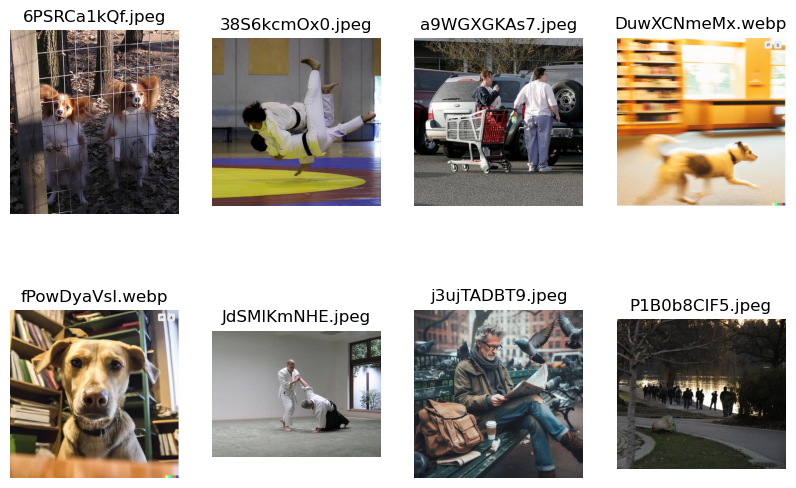

In [57]:
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = len(photos) // columns + 1
for indi, i in enumerate(photos):
    ax = fig.add_subplot(rows, columns, indi+1)
    img = cv2.imread(f'images/{i}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    ax.set_title(i)
    plt.axis('off')
plt.show()

Исходя из этих изображений и длительного перебора признаков, правильное разбиение поля meta имеет решающее значение в классификации.

# Источники

Про бета коэффициенты Адама<br/>
https://stats.stackexchange.com/questions/265400/deep-learning-how-does-beta-1-and-beta-2-in-the-adam-optimizer-affect-its-lear<br/>
https://arxiv.org/pdf/1412.6980.pdf

Модель персептрона и его модификации<br/>
https://github.com/deqky/CNN-template<br/>
https://keras.io/2.16/api/callbacks/early_stopping/<br/>
https://keras.io/2.16/api/optimizers/adam/<br/>
https://keras.io/2.16/api/losses/probabilistic_losses/<br/>
